In [1]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

import PIL, os, numpy as np, sys, cv2, zipfile, pandas as pd, tensorflow as tf, glob, imageio, time, tensorflow_docs.vis.embed as embed
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from google.colab import drive
from IPython import display
drive.mount("/content/gdrive")
#tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-y24jko6t
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-y24jko6t
  Resolved https://github.com/tensorflow/docs to commit a1abe995b09aca2768c03e509a146354828c6aa3
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.7.13.64986-py3-none-any.whl size=184123 sha256=5548ecea0c04955551b38bfddf61d36bc90bcffb286d99d3013011a67d0a61c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-md3xin0b/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs
Mounted at /content/gdrive


In [2]:
!cp "/content/gdrive/MyDrive/PUC/TCC/Notebooks/preTreinados/kaggle.json" "."
!chmod 600 kaggle.json
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
with zipfile.ZipFile("/content/skin-cancer-mnist-ham10000.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
del zip_ref
!mv /content/HAM10000_images_part_1/*.jpg /content/HAM10000_images_part_2

rm: cannot remove '/root/.kaggle': No such file or directory
100% 5.18G/5.20G [00:36<00:00, 216MB/s]
100% 5.20G/5.20G [00:36<00:00, 152MB/s]


In [3]:
datasetMetadata = pd.read_csv("/content/HAM10000_metadata.csv")
datasetMetadata = datasetMetadata.drop(columns=['dx_type','age','sex','localization']) # Non-utilized columns
datasetMetadata = datasetMetadata.rename(columns={"lesion_id": "lesionId",
                                                  "image_id": "imageId",
                                                  "dx": "cancerId"})
datasetMetadata['duplicate'] = datasetMetadata['lesionId']      # Creating a column to indicate if the lesion has more than one image

uniqueLesions = datasetMetadata.groupby('lesionId').count()     # Counts the number of lesions for each id
uniqueLesions = uniqueLesions[uniqueLesions['imageId'] == 1]    # Filter lesions which ones have unique id
uniqueLesions.reset_index(inplace = True)                       # Add default index column
uniqueLesions = uniqueLesions['lesionId'].values.tolist()       # Extracts the indexes into a list

datasetMetadata['duplicate'] = datasetMetadata['lesionId'].apply(lambda x: False if x in uniqueLesions else True) # Fill the rows indicating if the lesion has a duplicated image

del uniqueLesions
datasetMetadata = datasetMetadata[~((datasetMetadata['lesionId'].duplicated()) & (datasetMetadata['duplicate']))]
cancerType = {
    'akiec': 0, # 0.0 - 'Doenca de Bowens'
    'bcc':   1, # 1.0 - 'Carcinoma basocelular'
    'bkl':   2, # 2.0 - 'Keratose benigna'
    'df':    3, # 3.0 - 'Dermatofibroma'
    'vasc':  4, # 4.0 - 'Lesao vascular'
    'mel':   5, # 5.0 - 'Melanoma'
    'nv':    6  # 6.0 - 'Nevo melanocitico'
}
num_classes = len(cancerType)

In [4]:
images = []

for index, row in datasetMetadata.iterrows():
    if row['cancerId'] == 'mel':
      img = cv2.imread(''.join(['/content/HAM10000_images_part_2/', row['imageId'], '.jpg']))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Invert color BGR => RGB
      img = cv2.resize(img, (256, 256))          # Resize the image according to params provided
      img = (img - 127.5) / 127.5                # Normalize image to generator recognize values [-1,1]
      images.append(img)

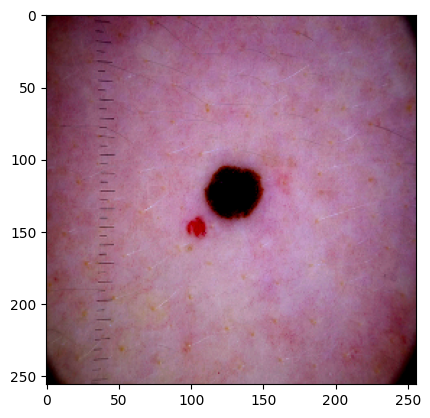

In [5]:
plt.imshow(images[0])
plt.show()

In [6]:
batch = 614

melanomaTraining = tf.data.Dataset.from_tensor_slices(images).batch(batch)

In [23]:
def generatorModel():
  model = tf.keras.Sequential()
  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((8, 8, 256)))
  assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

  model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 8, 8, 256)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 8, 8, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 16, 16, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 32, 32, 32)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 64, 64, 16)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 128, 128, 8)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) # Last layer need to have the tanh activation
  assert model.output_shape == (None, 256, 256, 3)

  return model

def discriminatorModel():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[256, 256, 3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model
genModel = generatorModel()
discModel = discriminatorModel()

In [24]:
# This method returns a helper function to compute cross entropy loss
crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminatorLoss(realOutput, fakeOutput):
    realLoss = crossEntropy(tf.ones_like(realOutput), realOutput)
    fakeLoss = crossEntropy(tf.zeros_like(fakeOutput), fakeOutput)
    totalLoss = realLoss + fakeLoss
    return totalLoss

def generatorLoss(fakeOutput):
    #mse_loss = tf.keras.losses.MeanSquaredError()
    #return mse_loss(target_images, fake_output)
    return crossEntropy(tf.ones_like(fakeOutput), fakeOutput)

generatorOptimizer = tf.keras.optimizers.Adam(1e-4)
discriminatorOptimizer = tf.keras.optimizers.Adam(1e-4)

In [25]:
checkpointDir = './training_checkpoints'
checkpointPrefix = os.path.join(checkpointDir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generatorOptimizer,
                                 discriminator_optimizer=discriminatorOptimizer,
                                 generator=genModel,
                                 discriminator=discModel)

In [26]:
epochs = 100
noiseDim = 100
examplesToGen = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([examplesToGen, noiseDim])

In [27]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([batch, noiseDim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generatedImgs = genModel(noise, training=True)
      realOutput = discModel(images, training=True)
      fakeOutput = discModel(generatedImgs, training=True)

      genLoss = generatorLoss(fakeOutput)
      discLoss = discriminatorLoss(realOutput, fakeOutput)

    gradientsGenerator = gen_tape.gradient(genLoss, genModel.trainable_variables)
    gradientsDiscriminator = disc_tape.gradient(discLoss, discModel.trainable_variables)

    generatorOptimizer.apply_gradients(zip(gradientsGenerator, genModel.trainable_variables))
    discriminatorOptimizer.apply_gradients(zip(gradientsDiscriminator, discModel.trainable_variables))
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for img in dataset:
      train_step(img)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      # Produce images for the GIF as you go
      generate_and_save_images(genModel, epoch + 1, seed)
      checkpoint.save(file_prefix = checkpointPrefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

  # Generate after the final epoch
  generate_and_save_images(genModel,epochs,seed)
def generate_and_save_images(model, epoch, testInput):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(testInput, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i + 1)
      plt.imshow(predictions[i, :, :, 0])
      #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [28]:
for img in melanomaTraining:
  print(img.shape)

test = os.listdir('.')
for item in test:
    if item.startswith("image_at_epoch_"):
        os.remove(item)

(614, 256, 256, 3)


Time for epoch 1 is 6.944786787033081 sec
Time for epoch 2 is 0.24875926971435547 sec
Time for epoch 3 is 1.0020325183868408 sec
Time for epoch 4 is 0.97967529296875 sec
Time for epoch 5 is 0.9781002998352051 sec
Time for epoch 6 is 0.9802403450012207 sec
Time for epoch 7 is 0.9799156188964844 sec
Time for epoch 8 is 0.9768073558807373 sec
Time for epoch 9 is 0.9827594757080078 sec
Time for epoch 10 is 0.9795408248901367 sec
Time for epoch 11 is 0.9789423942565918 sec
Time for epoch 12 is 0.9790585041046143 sec
Time for epoch 13 is 0.9786727428436279 sec
Time for epoch 14 is 0.9802110195159912 sec


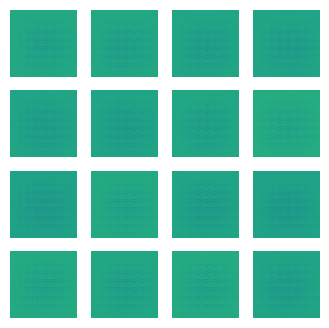

Time for epoch 15 is 2.6664280891418457 sec
Time for epoch 16 is 0.24765229225158691 sec
Time for epoch 17 is 0.9778025150299072 sec
Time for epoch 18 is 0.9790692329406738 sec
Time for epoch 19 is 0.9786078929901123 sec
Time for epoch 20 is 0.9808793067932129 sec
Time for epoch 21 is 0.9795165061950684 sec
Time for epoch 22 is 0.9796640872955322 sec
Time for epoch 23 is 0.9781558513641357 sec
Time for epoch 24 is 0.9794528484344482 sec
Time for epoch 25 is 0.9792354106903076 sec
Time for epoch 26 is 0.9788675308227539 sec
Time for epoch 27 is 0.9769494533538818 sec
Time for epoch 28 is 0.9799628257751465 sec
Time for epoch 29 is 0.9775989055633545 sec


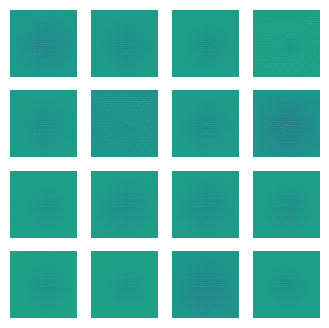

Time for epoch 30 is 2.6164767742156982 sec
Time for epoch 31 is 0.26268529891967773 sec
Time for epoch 32 is 0.980626106262207 sec
Time for epoch 33 is 0.9769127368927002 sec
Time for epoch 34 is 0.9783694744110107 sec
Time for epoch 35 is 0.9773659706115723 sec
Time for epoch 36 is 0.9780910015106201 sec
Time for epoch 37 is 0.9788777828216553 sec
Time for epoch 38 is 0.9739584922790527 sec
Time for epoch 39 is 0.9779391288757324 sec
Time for epoch 40 is 0.9792444705963135 sec
Time for epoch 41 is 0.9777038097381592 sec
Time for epoch 42 is 0.9766550064086914 sec
Time for epoch 43 is 0.9780068397521973 sec
Time for epoch 44 is 0.9800431728363037 sec


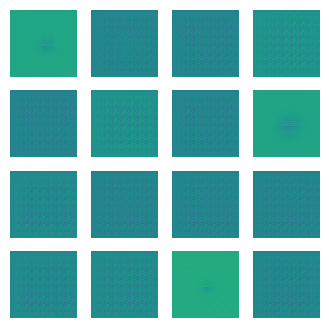

Time for epoch 45 is 2.9263060092926025 sec
Time for epoch 46 is 0.24992895126342773 sec
Time for epoch 47 is 0.9801855087280273 sec
Time for epoch 48 is 0.977818489074707 sec
Time for epoch 49 is 0.9803934097290039 sec
Time for epoch 50 is 0.9793126583099365 sec
Time for epoch 51 is 0.9791073799133301 sec
Time for epoch 52 is 0.9757983684539795 sec
Time for epoch 53 is 0.9804706573486328 sec
Time for epoch 54 is 0.9777233600616455 sec
Time for epoch 55 is 0.976525068283081 sec
Time for epoch 56 is 0.9781386852264404 sec
Time for epoch 57 is 0.9807271957397461 sec
Time for epoch 58 is 0.9786224365234375 sec
Time for epoch 59 is 0.9814138412475586 sec


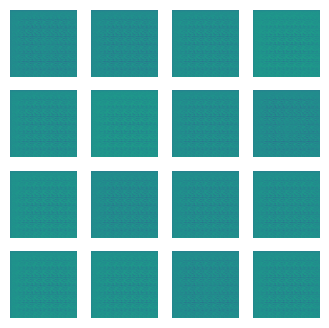

Time for epoch 60 is 2.6522598266601562 sec
Time for epoch 61 is 0.24933791160583496 sec
Time for epoch 62 is 0.9783051013946533 sec
Time for epoch 63 is 0.9796011447906494 sec
Time for epoch 64 is 0.9774973392486572 sec
Time for epoch 65 is 0.9772131443023682 sec
Time for epoch 66 is 0.9783389568328857 sec
Time for epoch 67 is 0.9786763191223145 sec
Time for epoch 68 is 0.9775238037109375 sec
Time for epoch 69 is 0.9794588088989258 sec
Time for epoch 70 is 0.9779906272888184 sec
Time for epoch 71 is 0.990553617477417 sec
Time for epoch 72 is 0.9789011478424072 sec
Time for epoch 73 is 0.9807722568511963 sec
Time for epoch 74 is 0.978945255279541 sec


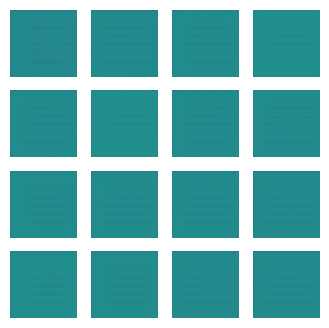

Time for epoch 75 is 2.6449484825134277 sec
Time for epoch 76 is 0.24774551391601562 sec
Time for epoch 77 is 0.9783103466033936 sec
Time for epoch 78 is 0.9791901111602783 sec
Time for epoch 79 is 0.978816032409668 sec
Time for epoch 80 is 0.9788999557495117 sec
Time for epoch 81 is 0.9777519702911377 sec
Time for epoch 82 is 0.9782788753509521 sec
Time for epoch 83 is 0.9780862331390381 sec
Time for epoch 84 is 0.9789612293243408 sec
Time for epoch 85 is 0.9790229797363281 sec
Time for epoch 86 is 0.978785514831543 sec
Time for epoch 87 is 0.9794492721557617 sec
Time for epoch 88 is 0.977971076965332 sec
Time for epoch 89 is 0.980687141418457 sec


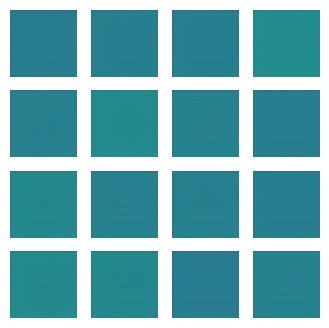

Time for epoch 90 is 2.6442365646362305 sec
Time for epoch 91 is 0.2512624263763428 sec
Time for epoch 92 is 0.9787623882293701 sec
Time for epoch 93 is 0.9914453029632568 sec
Time for epoch 94 is 0.9798808097839355 sec
Time for epoch 95 is 0.9800403118133545 sec
Time for epoch 96 is 0.9808778762817383 sec
Time for epoch 97 is 0.9792017936706543 sec
Time for epoch 98 is 0.9795994758605957 sec
Time for epoch 99 is 0.9773385524749756 sec
Time for epoch 100 is 0.9784338474273682 sec


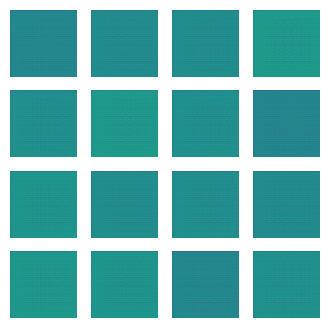

In [29]:
#with tf.device('/GPU:0'):
train(melanomaTraining, epochs)
checkpoint.restore(tf.train.latest_checkpoint(checkpointDir))

<ipython-input-30-cb4dadf34178>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-30-cb4dadf34178>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



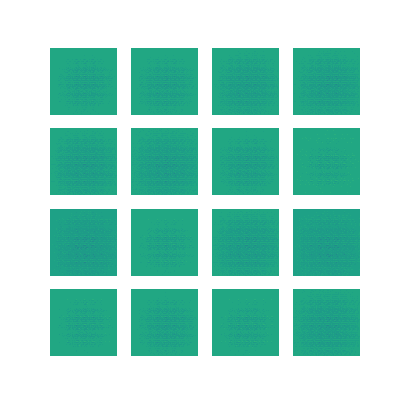

In [30]:
# Display a single image using the epoch number
def displayImg(epoch):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch))
displayImg(epochs)
animFile = 'dcgan.gif'

with imageio.get_writer(animFile, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
embed.embed_file(animFile)